In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score
from tensorflow.keras import Sequential, Input, layers


import sys
sys.path.append('../src')

from src.utils.data import get_csv_from_bq,select_tomo_ids

#from utils.model_plot import plot_history2
from src.utils.model_plot import plot_history_regression
from src.ml_logic.preprocess import batches_images_ram,selection_images_labels,read_img_jpg

In [4]:
#df = get_csv_from_bq()
#df.head(10)

In [3]:
df = pd.read_csv('../data/csv_raw/train_labels.csv')
df.head(10)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
0,0,16,tomo_049310,-1.0,-1.0,-1.0,500,924,956,19.7,0
1,1,30,tomo_098751,-1.0,-1.0,-1.0,500,924,956,16.1,0
2,2,54,tomo_136c8d,-1.0,-1.0,-1.0,500,924,956,19.7,0
3,3,59,tomo_146de2,-1.0,-1.0,-1.0,500,924,956,16.1,0
4,4,84,tomo_1dc5f9,-1.0,-1.0,-1.0,500,924,956,19.7,0
5,5,121,tomo_28f9c1,-1.0,-1.0,-1.0,500,924,956,16.1,0
6,6,173,tomo_39b15b,-1.0,-1.0,-1.0,500,924,956,16.1,0
7,7,181,tomo_3b8291,-1.0,-1.0,-1.0,500,924,956,19.7,0
8,8,193,tomo_40b215,-1.0,-1.0,-1.0,500,924,956,16.1,0
9,9,219,tomo_4baff0,-1.0,-1.0,-1.0,500,924,956,16.1,0


In [31]:
#print('y size ',df_no_1['Array_shape_axis_1'].value_counts())
#print('x size ',df_no_1['Array_shape_axis_2'].value_counts())

In [32]:
#x_size = df_no_1['Array_shape_axis_2'].min()
#y_size = df_no_1['Array_shape_axis_1'].max()
#print(x_size,y_size)

In [40]:
filtered_image_paths,labels = selection_images_labels(df,  'mean_image', num_slices=[300], num_motors=[1],
                       y_shape_range=(960, 960), x_shape_range=(928, 928))

/Users/benedettaveronesi/code/mc-will/BYU_Locating-Bacterial_Flagellar_Motors_2025/src/ml_logic/preprocess.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['motor_coord'] = df_select.apply(lambda row: (row['Motor_axis_2'], row['Motor_axis_1']), axis=1).copy()


In [41]:

#dataset_new = batches_images_ram(read_img_jpg,filtered_image_paths,labels)
train_ds, val_ds, test_ds = batches_images_ram(
    read_img_jpg,
    filtered_image_paths,
    labels,
    shuffle=True,
    batch_size=32,
    split=True,
    val_fraction=0.2,
    test_fraction=0.2,
    seed=42)

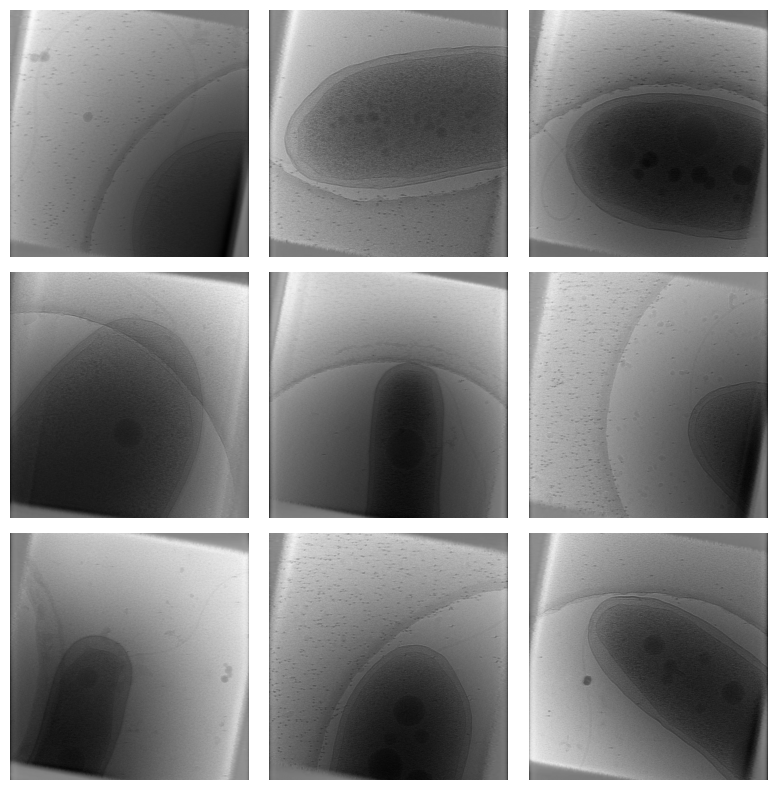

In [43]:
import matplotlib.pyplot as plt

# Take one batch (e.g., 32 images)
for batch in train_ds.take(1):
    images, _ = batch  # just images
    break

# Plot first 9 images in a 3x3 grid
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = tf.squeeze(images[i])
    plt.imshow(img.numpy(),cmap='gray')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [50]:
df

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
0,0,16,tomo_049310,-1.0,-1.0,-1.0,500,924,956,19.7,0
1,1,30,tomo_098751,-1.0,-1.0,-1.0,500,924,956,16.1,0
2,2,54,tomo_136c8d,-1.0,-1.0,-1.0,500,924,956,19.7,0
3,3,59,tomo_146de2,-1.0,-1.0,-1.0,500,924,956,16.1,0
4,4,84,tomo_1dc5f9,-1.0,-1.0,-1.0,500,924,956,19.7,0
...,...,...,...,...,...,...,...,...,...,...,...
732,732,99,tomo_226cd8,366.0,693.0,269.0,500,928,960,13.1,10
733,733,100,tomo_226cd8,386.0,693.0,319.0,500,928,960,13.1,10
734,734,101,tomo_226cd8,388.0,671.0,433.0,500,928,960,13.1,10
735,735,102,tomo_226cd8,411.0,318.0,740.0,500,928,960,13.1,10


In [44]:
img,label = read_img_jpg(filtered_image_paths[0], labels[1])
img_shape = img.shape
img_shape

TensorShape([960, 928, 1])

In [45]:
def initiate_model():

    model = Sequential()
     ### First Convolution & MaxPooling
    model.add(Input(shape=(960, 928, 1)))
    model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Conv2D(64, (4,4), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))

    ## Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(10,activation='relu'))

    model.add(layers.Dense(2,activation='linear'))

    return model

In [11]:
model = initiate_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 958, 926, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 319, 308, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 316, 305, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 105, 101, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 678720)            0         
                                                                 
 dense (Dense)               (None, 10)                6

In [20]:
def compile_model(model):
    ### Model compilation
    model.compile(loss='mse',optimizer='adam',metrics=['mse'], run_eagerly=True)
    return model


In [46]:
#dataset_size = len(filtered_image_paths)

#train_size = int(0.6 * dataset_size)
#val_size = int(0.2 * dataset_size)
#test_size = dataset_size - train_size - val_size  # to ensure sum equals total

# Shuffle the full dataset first (already done in your case)
#full_dataset = dataset_new.shuffle(dataset_size, seed=42)


# test_ds = first test_size elements
#test_ds = full_dataset.take(test_size)

# val_ds = next val_size elements
#val_ds = full_dataset.skip(test_size).take(val_size)

# train_ds = rest of the dataset
#train_ds = full_dataset.skip(test_size + val_size)

# Preprocess both
#train_ds = train_ds.batch(32)
#val_ds = val_ds.batch(32)
#test_ds = test_ds.batch(32)


In [49]:
for images, labels in val_ds.take(1):
    print(images.shape, images.dtype)
    print(labels.shape, labels.dtype)

(32, 960, 928, 1) <dtype: 'float32'>
(32, 2) <dtype: 'float32'>


In [51]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

model = initiate_model()
model = compile_model(model)

es = EarlyStopping(patience=10)
history = model.fit(
      train_ds,
      validation_data=val_ds,
      #shuffle= True,
      batch_size=32,
      epochs=50,
      callbacks=[es],
      verbose=1
      )

Epoch 1/50
4/4 [==============================] - 65s 15s/step - loss: 221614.6875 - mse: 221614.6875 - val_loss: 94820.1875 - val_mse: 94820.1875
Epoch 2/50
4/4 [==============================] - 63s 14s/step - loss: 75224.6719 - mse: 75224.6719 - val_loss: 97754.3359 - val_mse: 97754.3359
Epoch 3/50
4/4 [==============================] - 63s 15s/step - loss: 55508.6211 - mse: 55508.6211 - val_loss: 41475.3672 - val_mse: 41475.3672
Epoch 4/50
4/4 [==============================] - 56s 13s/step - loss: 44286.9219 - mse: 44286.9219 - val_loss: 39832.3672 - val_mse: 39832.3672
Epoch 5/50
4/4 [==============================] - 61s 15s/step - loss: 36532.9648 - mse: 36532.9648 - val_loss: 31924.4805 - val_mse: 31924.4805
Epoch 6/50
4/4 [==============================] - 56s 13s/step - loss: 31120.7402 - mse: 31120.7402 - val_loss: 33769.8125 - val_mse: 33769.8125
Epoch 7/50
4/4 [==============================] - 55s 13s/step - loss: 31920.1504 - mse: 31920.1504 - val_loss: 25854.9805 - val

(0, 23) (0, 221614.6875)


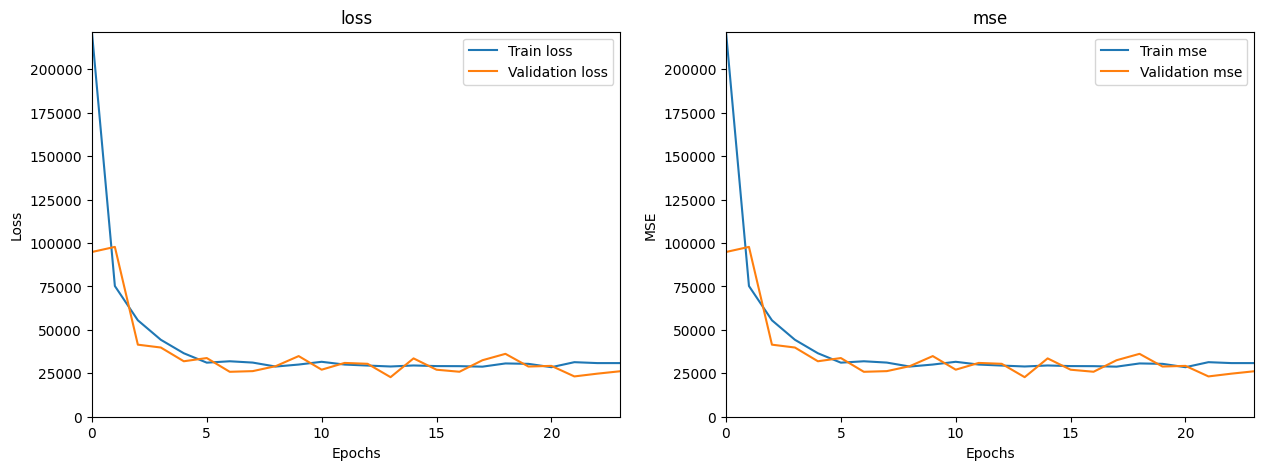

In [52]:
plot_history_regression(history)
